# 📘 Forecasting por Producto con AutoGluon TabularPredictor


## 🔢 Carga de librerías

In [33]:
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 📦 Carga y preprocesamiento de datos

Levantamos el archivo parquet generado en la etapa anterior, verificamos la estructura y visualizamos los primeros registros.


In [37]:
ruta_parquet = "C:/Developer/Laboratorio_III/data/dataset_product_periodo.parquet"
df = pd.read_parquet(ruta_parquet)
df = df.sort_values(['product_id', 'fecha'])

# Filter the DataFrame for the specified date
df_filtered = df[df['fecha'] == '2019-12-01']
df_filtered


,product_id,periodo,tn_total,clientes_positivos,cat1,cat2,cat3,brand,sku_size,descripcion,fecha,mm-yyyy,quarter
35,20001,201912,1504.68856,176,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,2019-12-01,12-2019,2019Q4
71,20002,201912,1087.30855,98,HC,ROPA LAVADO,Liquido,LIMPIEX,3000.0,Maquina 1er lavado,2019-12-01,12-2019,2019Q4
107,20003,201912,892.50129,161,FOODS,ADEREZOS,Mayonesa,NATURA,475.0,Regular sin TACC,2019-12-01,12-2019,2019Q4
143,20004,201912,637.90002,158,FOODS,ADEREZOS,Mayonesa,NATURA,240.0,Regular sin TACC,2019-12-01,12-2019,2019Q4
179,20005,201912,593.24443,142,FOODS,ADEREZOS,Mayonesa,NATURA,120.0,Regular sin TACC,2019-12-01,12-2019,2019Q4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31384,21265,201912,0.05007,5,PC,PIEL1,CUIDADO ESPECIAL,LANCOME,32.0,mascara facial 2,2019-12-01,12-2019,2019Q4
31394,21266,201912,0.05121,5,PC,PIEL1,CUIDADO ESPECIAL,LANCOME,32.0,mascara facial 1,2019-12-01,12-2019,2019Q4
31404,21267,201912,0.01569,4,PC,PIEL1,Cara,NIVEA,250.0,Limpieza Facial,2019-12-01,12-2019,2019Q4
31449,21271,201912,0.00298,3,REF,TE,Frutas,TWININGS,20.0,Frutas,2019-12-01,12-2019,2019Q4


# 🧠 Creación de features: lags, rolling, diferencias, min y max
### Lags hasta 6 períodos

In [38]:
for lag in range(1, 12):
    df[f'tn_lag_{lag}'] = df.groupby('product_id')['tn_total'].shift(lag)
    df[f'tn_diff_lag_{lag}'] = df['tn_total'] - df[f'tn_lag_{lag}']

# Rolling de media, min y max (últimos 3 períodos)
df['tn_rollmean_3'] = (
    df.groupby('product_id')['tn_total']
    .shift(1)
    .rolling(window=6)
    .mean()
    .reset_index(drop=True)
)
df['tn_rollmin_3'] = (
    df.groupby('product_id')['tn_total']
    .shift(1)
    .rolling(window=6)
    .min()
    .reset_index(drop=True)
)
df['tn_rollmax_3'] = (
    df.groupby('product_id')['tn_total']
    .shift(1)
    .rolling(window=6)
    .max()
    .reset_index(drop=True)
)

if not np.issubdtype(df['fecha'].dtype, np.datetime64):
    df['fecha'] = pd.to_datetime(df['fecha'])
df['quarter'] = df['fecha'].dt.quarter


## ✅ Definir horizonte de predicción (M+2)

In [43]:
# Paso 1: Separar el conjunto de test ANTES de crear target
df_test = df[df['fecha'] == '2019-12-01'].copy()

horizonte = 2
df['target'] = df.groupby('product_id')['tn_total'].shift(-horizonte)
df_modelo = df.dropna(subset=['target'])


# ✅ Separar en entrenamiento y test

In [44]:
df_train = df_modelo[df_modelo['fecha'] <= '2019-10-01'].copy()


# ✅ Dataset final para entrenamiento
### Usamos todas las columnas numéricas y categóricas útiles

In [45]:
target_col = 'target'
excluir = ['tn_total', 'target_future', 'tn_future', 'target', 'fecha']
features = [col for col in df_modelo.columns if col not in excluir]

X_train = df_train[features]
y_train = df_train[target_col]

X_test = df_test[features]
y_test = df_test[target_col]

train_set = X_train.copy()
train_set[target_col] = y_train

# ✅ Entrenamiento del TabularPredictor

In [46]:
custom_hyperparameters = {
    'GBM': {
        'extra_trees': True,
        'num_boost_round': 500,
        'learning_rate': 0.03,
        'ag_args': {'name_suffix': '_custom'}
    },
    'CAT': {},
    'XGB': {},
    'RF': {},
    'XT': {},
    'KNN': {},
    'NN_TORCH': {},
    'FASTAI': {}
}

predictor = TabularPredictor(
    label=target_col,
    problem_type='regression',
    eval_metric='mean_absolute_error',
    path='autogluon_tabular_predictor'
)
predictor.fit(train_set, time_limit=3600, hyperparameters=custom_hyperparameters)


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.9.21
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
CPU Count:          14
Memory Avail:       3.86 GB / 15.31 GB (25.2%)
Disk Space Avail:   235.15 GB / 475.95 GB (49.4%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference speed.
	presets='good'         : Good acc

# ✅ Preparación de datos para predicción en 202002

In [53]:
y_pred = predictor.predict(X_test)
df_test['tn_pred'] = y_pred

df_test

,product_id,periodo,tn_total,clientes_positivos,cat1,cat2,cat3,brand,sku_size,descripcion,...,tn_diff_lag_9,tn_lag_10,tn_diff_lag_10,tn_lag_11,tn_diff_lag_11,tn_rollmean_3,tn_rollmin_3,tn_rollmax_3,target,tn_pred
35,20001,201912,1504.68856,176,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,...,34.03203,1259.09363,245.59493,1275.77351,228.91505,1444.859933,1109.93769,1678.99318,NaN,1404.526367
71,20002,201912,1087.30855,98,HC,ROPA LAVADO,Liquido,LIMPIEX,3000.0,Maquina 1er lavado,...,3.68303,1043.01349,44.29506,1266.78751,-179.47896,1216.982983,813.78215,1979.53635,NaN,1181.838257
107,20003,201912,892.50129,161,FOODS,ADEREZOS,Mayonesa,NATURA,475.0,Regular sin TACC,...,254.46119,758.32657,134.17472,964.76919,-72.26790,835.102808,635.59563,1081.36645,NaN,805.259583
143,20004,201912,637.90002,158,FOODS,ADEREZOS,Mayonesa,NATURA,240.0,Regular sin TACC,...,18.12918,441.70332,196.19670,511.33713,126.56289,707.642135,482.13372,1064.69633,NaN,566.998901
179,20005,201912,593.24443,142,FOODS,ADEREZOS,Mayonesa,NATURA,120.0,Regular sin TACC,...,105.03056,409.89950,183.34493,363.58438,229.66005,773.672883,536.66800,996.78275,NaN,510.912659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31384,21265,201912,0.05007,5,PC,PIEL1,CUIDADO ESPECIAL,LANCOME,32.0,mascara facial 2,...,0.03414,NaN,NaN,NaN,NaN,0.048168,0.01593,0.10921,NaN,-0.365674
31394,21266,201912,0.05121,5,PC,PIEL1,CUIDADO ESPECIAL,LANCOME,32.0,mascara facial 1,...,0.03414,NaN,NaN,NaN,NaN,0.056698,0.01480,0.11831,NaN,-0.381955
31404,21267,201912,0.01569,4,PC,PIEL1,Cara,NIVEA,250.0,Limpieza Facial,...,-0.20009,NaN,NaN,NaN,NaN,0.054910,0.01830,0.09676,NaN,0.020452
31449,21271,201912,0.00298,3,REF,TE,Frutas,TWININGS,20.0,Frutas,...,-0.00521,0.01041,-0.00743,0.00745,-0.00447,0.016965,0.00445,0.02933,NaN,-0.647355


In [60]:
# ✅ Reemplazar valores negativos en la predicción por 0
df_test['tn_pred'] = df_test['tn_pred'].clip(lower=0)

# ✅ Recalcular métricas
mae = mean_absolute_error(df_test['tn_total'], df_test['tn_pred'])
rmse = mean_squared_error(df_test['tn_total'], df_test['tn_pred'], squared=False)
wape = np.mean(np.abs(df_test['tn_total'] - df_test['tn_pred']) / df_test['tn_total'].replace(0, np.nan))
mape = wape

print(f"\n📊 Evaluación (después de reemplazar negativos por 0):")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"WAPE: {wape:.2%}")
print(f"MAPE: {mape:.2%}")


📊 Evaluación (después de reemplazar negativos por 0):
MAE:  7.25
RMSE: 18.32
WAPE: 466.62%
MAPE: 466.62%


c:\Users\FSONZOGNI\AppData\Local\anaconda3\envs\labo_III\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# ✅ 10. Leaderboard de modelos

In [55]:
lb = predictor.leaderboard(df_train, silent=True)
print(lb)


                 model  score_test  score_val          eval_metric  \
0              XGBoost   -1.037401  -7.633777  mean_absolute_error   
1  WeightedEnsemble_L2   -2.449984  -7.359801  mean_absolute_error   
2             CatBoost   -3.230163  -7.728108  mean_absolute_error   
3           ExtraTrees   -3.877086  -8.094085  mean_absolute_error   
4         RandomForest   -3.961682  -8.256614  mean_absolute_error   
5      LightGBM_custom   -7.503637  -8.378865  mean_absolute_error   
6           KNeighbors  -63.658854 -59.635852  mean_absolute_error   

   pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  \
0        1.577851       0.130531   36.002649                 1.577851   
1        2.778183       0.266297  494.770358                 0.010372   
2        0.293642       0.038051  449.880000                 0.293642   
3        0.779214       0.078511    7.147924                 0.779214   
4        0.628540       0.078922   33.289940                 0.628540   
5

# ✅ 11. Importancia de variables

These features in provided data are not utilized by the predictor and will be ignored: ['tn_total', 'fecha']
Computing feature importance via permutation shuffling for 36 features using 5000 rows with 5 shuffle sets...
	228.44s	= Expected runtime (45.69s per shuffle set)
	71.66s	= Actual runtime (Completed 5 of 5 shuffle sets)


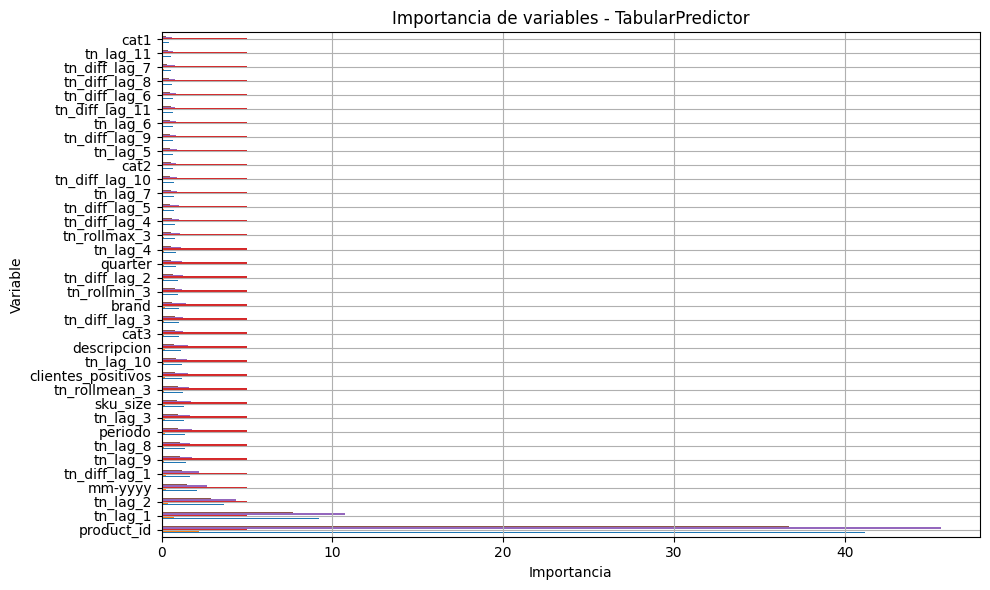

In [56]:
importancia = predictor.feature_importance(df_train)
importancia.plot(kind='barh', figsize=(10,6), legend=False)
plt.title('Importancia de variables - TabularPredictor')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.grid(True)
plt.tight_layout()
plt.show()


# ✅ Predicción de 2020-02-01 usando datos de 2019-12-01

In [61]:
fecha_pred_input = pd.to_datetime('2019-12-01')
fecha_pred_output = pd.to_datetime('2020-02-01')

# Cargar IDs de productos a predecir
df_ids = pd.read_csv("C:/Developer/Laboratorio_III/data/product_id_apredecir201912.txt", sep='\t')
df_ids.rename(columns={'product_id': 'product_id'}, inplace=True)
product_ids_objetivo = df_ids['product_id'].unique()

# Filtrar features para esos productos en 2019-12-01
df_pred_202002 = df[(df['fecha'] == fecha_pred_input) & (df['product_id'].isin(product_ids_objetivo))].copy()
X_pred = df_pred_202002[features].copy()
y_pred_202002 = predictor.predict(X_pred)
df_pred_202002['tn_pred'] = y_pred_202002

# Reemplazar negativos
df_pred_202002['tn_pred'] = df_pred_202002['tn_pred'].clip(lower=0)

# Exportar CSV
df_pred_202002[['product_id', 'tn_pred']].rename(columns={'tn_pred': 'tn'}).to_csv('pronostico_202002.csv', index=False)
print("\n📁 Predicciones exportadas a pronostico_202002.csv")


📁 Predicciones exportadas a pronostico_202002.csv
